In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import seaborn as sns
from sklearn.cluster import KMeans

# Load Data into DataFrame
df_Avoidable_Death = pd.read_csv('Avoidable_Death.csv',encoding = 'ISO-8859-1')
df_Health_Risk_Factor = pd.read_csv('Health_Risk_Factor.csv',encoding = 'ISO-8859-1')

# Function to plot linear regression for scatter plot 
# reference from STACKOVERFLOW https://stackoverflow.com/
# Argument: slope(float), intercept(float)
# Return: None
def LinearRegressionLinePlot(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color='black')

# Data Preprocessing 

## Data Formating

In [2]:
# Drop noisy column(useless)
df_Health_Risk_Factor = df_Health_Risk_Factor.drop(columns = [" ste_name"])
df_Avoidable_Death = df_Avoidable_Death.drop(columns = [" ste_name"])

In [3]:
# Rename
df_Health_Risk_Factor.rename(columns={'alchl_p_2_asr':  'RiskAlcoholConsumption_per100',\
                                      ' frt_intk_2_asr':'FruitAdequateIntake_per100',\
                                      ' lga_code': 'lga_code',\
                                      ' lga_name': 'lga_name',\
                                      ' hbld_pres_2_asr':  'HighBloodPressure_per100',\
                                       ' ovrwgt_p_2_asr': 'Overweight_per100',\
                                      ' lw_excse_2_asr':'LowExercise_per100',\
                                      ' wst_meas_p_2_asr': 'RiskWaistMeasurement_per100',\
                                       ' smkrs_p_2_asr':'Somker_per100' ,\
                                      ' psych_dstrs_2_asr': 'PsychologicalDistress_per100',\
                                      ' obese_p_2_asr': 'obese_per100'}, inplace=True)

df_Avoidable_Death.rename(columns = {'lga_name': 'lga_name',\
                                     ' lga_code': 'lga_code',\
                                     ' avoid_dths_cancer_2_asr':'cancer_per100,000',\
                                       ' avoid_dths_diab_2_asr': 'diabetes_per100,000',\
                                     ' avoid_dths_colo_2_asr':'colorectal_per100,000' ,\
                                       ' avoid_dths_pulm_2_asr': 'pulmonary _per100,000',\
                                     ' avoid_dths_cerb_2_asr': 'cerebrovascular_per100,000'}, inplace = True)

In [4]:
# Change Column Position
df_Health_Risk_Factor = df_Health_Risk_Factor[['lga_code','lga_name','FruitAdequateIntake_per100',
                                               'RiskAlcoholConsumption_per100', 'HighBloodPressure_per100',
       'Overweight_per100', 'LowExercise_per100',
       'RiskWaistMeasurement_per100', 'Somker_per100',
       'PsychologicalDistress_per100', 'obese_per100']]

df_Avoidable_Death = df_Avoidable_Death[['lga_code',
       'lga_name','diabetes_per100,000', 'cerebrovascular_per100,000', 
                                         'colorectal_per100,000', 'cancer_per100,000',
       'pulmonary _per100,000']]

In [5]:
# Data sorting on 'lga_code' in ascending for both datasets
df_Avoidable_Death.sort_values(by = ['lga_code']);
df_Health_Risk_Factor.sort_values(by = ['lga_code']);

## Data Integrating

In [6]:
# Integrate two dataset on the feature 'lga_coded' and 'lga_name'
# Interated dataset of Avoidable Death and Health Risk Factor
left = df_Avoidable_Death
right = df_Health_Risk_Factor 
BigDF = pd.merge(left, right, on = ['lga_code', 'lga_name']) 


In [7]:
print(df_Avoidable_Death.keys())

Index(['lga_code', 'lga_name', 'diabetes_per100,000',
       'cerebrovascular_per100,000', 'colorectal_per100,000',
       'cancer_per100,000', 'pulmonary _per100,000'],
      dtype='object')


## Handling Missing Values

In [8]:
# Solution for Missing Value
Number_of_Null_Values_per_Row = BigDF.isnull().sum(axis = 1)
Index_of_Number_of_Null_Values_per_Row_Excess_Three = Number_of_Null_Values_per_Row\
.loc[Number_of_Null_Values_per_Row>3]

# Delete Records contains more than 3 missing value(exclusive)
BigDF = BigDF.drop(Index_of_Number_of_Null_Values_per_Row_Excess_Three.index)

# Fullfill the remain records have null value by mean value
Mean_Values_All = BigDF.mean()
BigDF_Keys = BigDF.keys()
for i in BigDF_Keys[2:]:
    BigDF[i].fillna(Mean_Values_All[i], inplace=True)
    
# Then separate two datasets for futher using
df_new_Avoidable_Death = BigDF.iloc[:, 2:7]
df_new_Health_Risk_Factor= BigDF.iloc[:, 7:16]

## Adding Values

In [9]:
# Add a new feature that is the sum of all kinds of avoidable death for every remian area
Avoidable_Death_Total = BigDF.iloc[:, 2:7].sum(axis=1)
BigDF['Avoidable_Death_Total'] = Avoidable_Death_Total
df_new_Avoidable_Death['Avoidable_Death_Total'] = Avoidable_Death_Total

# Add a new feature thar is the approximate sum of peolpe that have health risk factor for every remain area
# But does not contain FruitAdequateIntake_per100 feature since it is a healthy feature
Health_Risk_Factor_Total = BigDF.iloc[:, 8:16].sum(axis = 1)
BigDF['Health_Risk_Factor_Total'] = Health_Risk_Factor_Total
df_new_Health_Risk_Factor['Health_Risk_Factor_Total'] = Health_Risk_Factor_Total

#Ratio = Avoidable_Death_Total_Over_Health_Risk_Factor_Total
Ratio = BigDF['Avoidable_Death_Total']/BigDF['Health_Risk_Factor_Total']
BigDF['Ratio'] = Ratio

## Outliers Detection

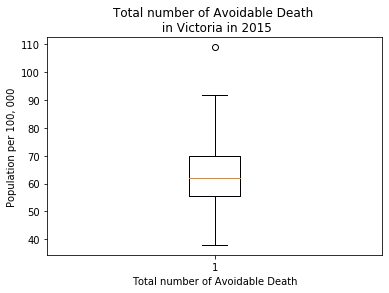

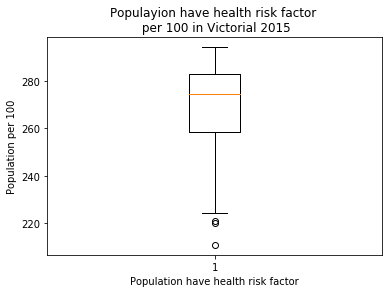

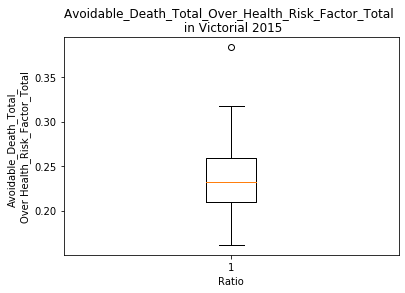

In [10]:
# Outlier Detection and Solving

# Boxplot for total number of avoidable death for each area per 100, 000
plt.boxplot(BigDF['Avoidable_Death_Total'])
plt.ylabel('Population per 100, 000')
plt.xlabel('Total number of Avoidable Death')
plt.title('Total number of Avoidable Death \n in Victoria in 2015')
plt.show()

# Boxplot for population have health risk factor per 100
plt.boxplot(BigDF['Health_Risk_Factor_Total'])
plt.ylabel('Population per 100')
plt.xlabel('Population have health risk factor')
plt.title('Populayion have health risk factor \n per 100 in Victorial 2015')
plt.show()

# Boxplot for ratio
plt.boxplot(BigDF['Ratio'])
plt.ylabel('Avoidable_Death_Total_\nOver Health_Risk_Factor_Total')
plt.xlabel('Ratio')
plt.title('Avoidable_Death_Total_Over_Health_Risk_Factor_Total \n in Victorial 2015')
plt.show()

In [11]:
# find the area with extremel hign number of people died from avoidable death -
# - by extracting the record with max Avoidable_Death_Total
BigDF.sort_values(['Avoidable_Death_Total'], ascending = False).head(1)

,lga_code,lga_name,"diabetes_per100,000","cerebrovascular_per100,000","colorectal_per100,000","cancer_per100,000","pulmonary _per100,000",FruitAdequateIntake_per100,RiskAlcoholConsumption_per100,HighBloodPressure_per100,Overweight_per100,LowExercise_per100,RiskWaistMeasurement_per100,Somker_per100,PsychologicalDistress_per100,obese_per100,Avoidable_Death_Total,Health_Risk_Factor_Total,Ratio
57,25810,Northern Grampians (S),11.9,13.3,13.3,53.9,16.5,45.6,18.4,21.3,35.2,71.0,66.3,22.6,15.5,33.5,108.9,283.8,0.383721


In [12]:
# find the area with extremel hign ratio
# - by extracting the record with max Ratio
BigDF.sort_values(['Ratio'], ascending = False).head(1)

,lga_code,lga_name,"diabetes_per100,000","cerebrovascular_per100,000","colorectal_per100,000","cancer_per100,000","pulmonary _per100,000",FruitAdequateIntake_per100,RiskAlcoholConsumption_per100,HighBloodPressure_per100,Overweight_per100,LowExercise_per100,RiskWaistMeasurement_per100,Somker_per100,PsychologicalDistress_per100,obese_per100,Avoidable_Death_Total,Health_Risk_Factor_Total,Ratio
57,25810,Northern Grampians (S),11.9,13.3,13.3,53.9,16.5,45.6,18.4,21.3,35.2,71.0,66.3,22.6,15.5,33.5,108.9,283.8,0.383721


# Data Visualisation and Analysis

## Total Avoidable Death in Victoria in 2015 

In [13]:
print("Total Avoidable Death in Vic in 2015 is %.0f people." %(BigDF['Avoidable_Death_Total'].sum()))

Total Avoidable Death in Vic in 2015 is 4795 people.


## Scatter Plot :Toal Avoidable Death Against Toal Health Risk Factor 

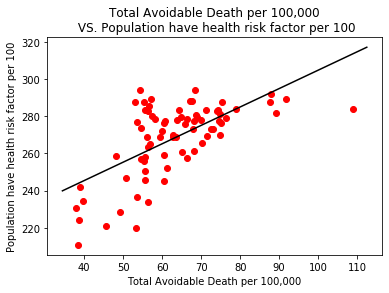

Slope:0.99, Intercept:205.78.
Pearson r is 0.64


In [14]:
# Scatter plot
plt.scatter(BigDF['Avoidable_Death_Total'], BigDF['Health_Risk_Factor_Total'], color='red')
plt.title("Total Avoidable Death per 100,000\n VS. Population have health risk factor per 100")
plt.ylabel("Population have health risk factor per 100")
plt.xlabel("Total Avoidable Death per 100,000")

# plot the linear regression line
Info = linregress(BigDF['Avoidable_Death_Total'], BigDF['Health_Risk_Factor_Total'])
LinearRegressionLinePlot(Info[0], Info[1])
plt.show()

print("Slope:%.2f," % (Info[0]), "Intercept:%.2f." % (Info[1]))
print("Pearson r is %.2f" % (BigDF['Avoidable_Death_Total'].corr(BigDF['Health_Risk_Factor_Total'])))

### Analysis
The above scatter graph shows a nearly strong correlation between total avoidable death and population having health risk factor. Thus move into more detail steps which is compare each feature in avoidable death and health risk factor.

## Heat Map: Pearson correlation matrix of features of avoidable death Against features of health risk factors

### Visulisation 

In [15]:
#compute the Pearson correlation matrix of features of avoidable death Against features of health risk factors
Corr_Matric_All = BigDF.iloc[:, 2:].corr()

Result = Corr_Matric_All[['diabetes_per100,000','cancer_per100,000',\
                 'colorectal_per100,000', 'pulmonary _per100,000',\
                'cerebrovascular_per100,000']].loc\
[['FruitAdequateIntake_per100','obese_per100', 'RiskWaistMeasurement_per100',\
 'LowExercise_per100', 'PsychologicalDistress_per100', 'Somker_per100', \
 'RiskAlcoholConsumption_per100', 'HighBloodPressure_per100',
       'Overweight_per100']]

In [16]:
# Display the correlation matrix
Result

,"diabetes_per100,000","cancer_per100,000","colorectal_per100,000","pulmonary _per100,000","cerebrovascular_per100,000"
FruitAdequateIntake_per100,-0.679572,-0.349278,-0.252379,-0.688747,-0.512067
obese_per100,0.483359,0.406812,0.260745,0.646961,0.481602
RiskWaistMeasurement_per100,0.461054,0.351885,0.268788,0.569118,0.460800
LowExercise_per100,0.519150,0.294986,0.302692,0.510635,0.512343
PsychologicalDistress_per100,0.460219,0.344817,0.101307,0.448457,0.421026
Somker_per100,0.585404,0.498519,0.269687,0.707041,0.493460
RiskAlcoholConsumption_per100,0.066692,0.161636,0.036597,0.299578,0.035149
HighBloodPressure_per100,0.025055,-0.119860,0.062885,-0.101960,-0.077770
Overweight_per100,-0.475175,-0.272801,-0.073200,-0.570848,-0.411096


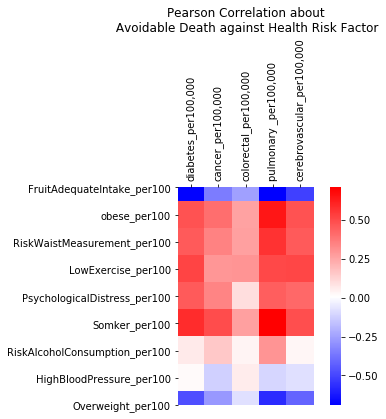

In [17]:
# plot the heatmap of correlation matrix
ax = sns.heatmap(Result, cmap="bwr", square = True)
ax.xaxis.tick_top()
plt.xticks(rotation = 90)
ax.set_title('Pearson Correlation about\n Avoidable Death against Health Risk Factor',\
             rotation='horizontal',x=0.5 ,y= -0.22)
plt.show()

### Analysis

By viewing the heat map above the following information could be generated
1. FruitAdequateIntake_per100 has a ***negative*** correlation with all kinds of avoidable death causes
2. obese_per100 has a ***positive*** correlation with all kinds of avoidable death causes
3. RiskWaistMearsurement_per100 has a ***positive*** correlation with all kinds of avoidable death causes
4. LowExercise_per100 has a ***positive*** correlation with all kinds of avoidable death causes
5. PsychologicalDistress_per100 has a ***positive*** correlation with all kinds of avoidable death causes
6. Somker_per100 has a ***positive*** correlation with all kinds of avoidable death causes
7. RiskAlcoholConsumption_per100 has ***almost no*** correlation with all kinds of avoidable death causes
8. HighBloodPressure_per100 has ***almost no*** correlation with all kinds of avoidable death causes
9. Overweight_per100 has a ***negative*** correlation with all kinds of avoidable death causes


- Summary
    - The information 1 to 6 is useful, cause they give good correlation and is reasonable.
    - The infomation 7, 8 and 9 is useless, because 7 and 8 give no correlation as well as 9 illustrates that as Overweight_per100 increases the each kinds of avoidable death become less. Which encourages us to be overweight, if we want to prevent avoidable death. This is not real and acceptable. 

    - Then, I am going to delete these three health risk factors.

### Drop features

In [18]:
BigDF = BigDF.drop(columns = ['RiskAlcoholConsumption_per100', 'HighBloodPressure_per100', 'Overweight_per100'])
df_new_Health_Risk_Factor = df_new_Health_Risk_Factor.drop(columns = ['RiskAlcoholConsumption_per100', 'HighBloodPressure_per100', 'Overweight_per100'])

In [19]:
print(df_new_Health_Risk_Factor.keys())

Index(['FruitAdequateIntake_per100', 'LowExercise_per100',
       'RiskWaistMeasurement_per100', 'Somker_per100',
       'PsychologicalDistress_per100', 'obese_per100',
       'Health_Risk_Factor_Total'],
      dtype='object')


### Recompute Pearson Correlation and Draw Heat Map 

In [20]:
#compute the Pearson correlation matrix of features of avoidable death Against features of health risk factors
Corr_Matric_All = BigDF.iloc[:, 2:].corr()

Result = Corr_Matric_All[['diabetes_per100,000','cancer_per100,000',\
                 'colorectal_per100,000', 'pulmonary _per100,000',\
                'cerebrovascular_per100,000']].loc\
[['FruitAdequateIntake_per100','obese_per100', 'RiskWaistMeasurement_per100',\
 'LowExercise_per100', 'PsychologicalDistress_per100', 'Somker_per100']]

In [21]:
# Display the correlation matrix
Result

,"diabetes_per100,000","cancer_per100,000","colorectal_per100,000","pulmonary _per100,000","cerebrovascular_per100,000"
FruitAdequateIntake_per100,-0.679572,-0.349278,-0.252379,-0.688747,-0.512067
obese_per100,0.483359,0.406812,0.260745,0.646961,0.481602
RiskWaistMeasurement_per100,0.461054,0.351885,0.268788,0.569118,0.460800
LowExercise_per100,0.519150,0.294986,0.302692,0.510635,0.512343
PsychologicalDistress_per100,0.460219,0.344817,0.101307,0.448457,0.421026
Somker_per100,0.585404,0.498519,0.269687,0.707041,0.493460


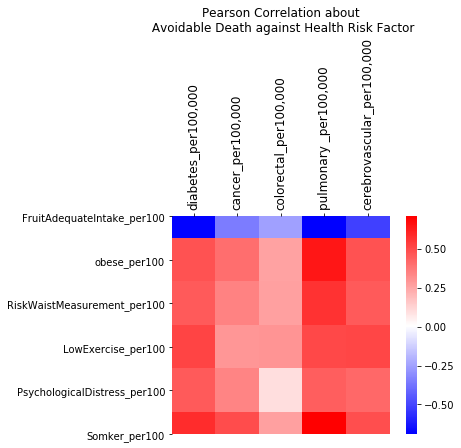

In [22]:
# plot the heatmap of correlation matrix
ax = sns.heatmap(Result, cmap="bwr", square = True)
ax.xaxis.tick_top()
plt.xticks(rotation = 90, fontsize = 12)
ax.set_title('Pearson Correlation about\n Avoidable Death against Health Risk Factor',\
             rotation='horizontal',x=0.5 ,y= -0.22)
plt.show()

## Bar Chart For Viewing Distribution

### Visualisation 

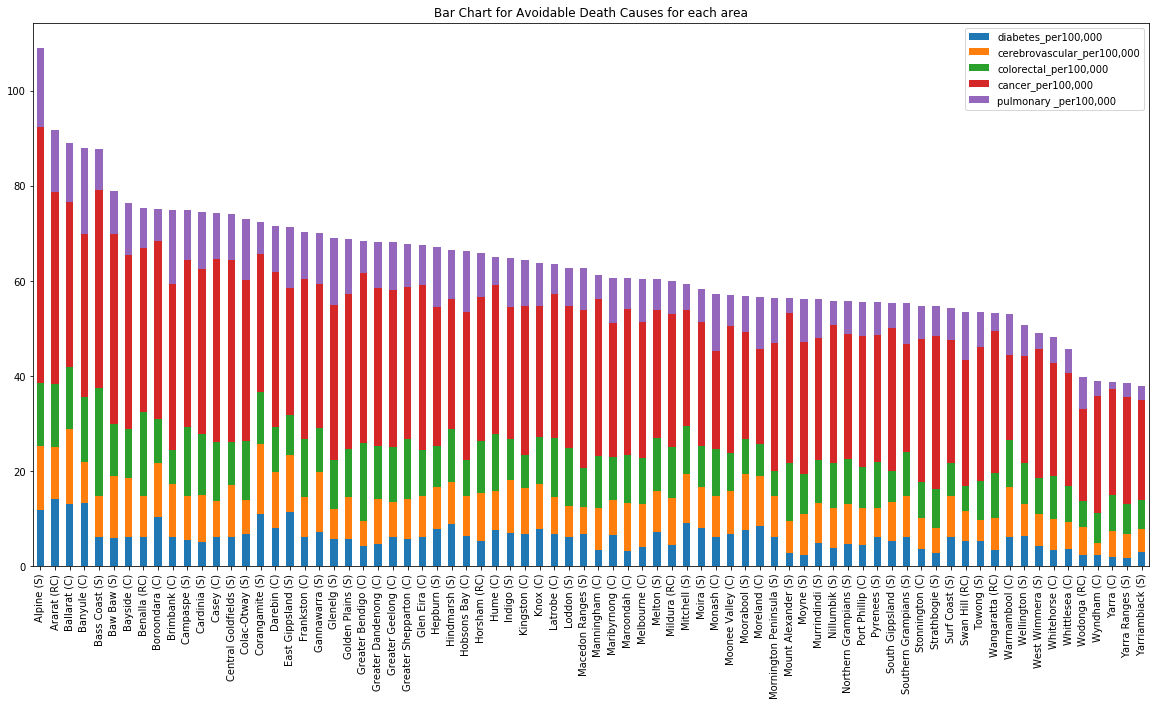

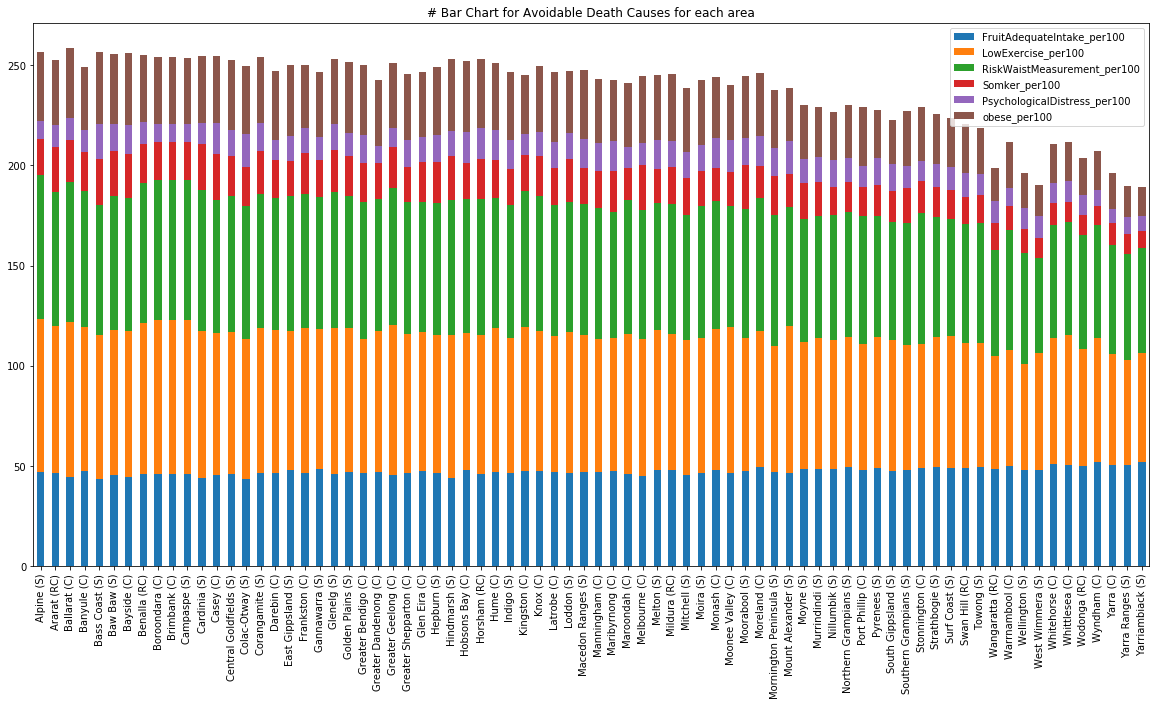

In [23]:
# Bar Chart for Avoidable Death Causes for each area
df1 = df_new_Avoidable_Death.sort_values(by = "Avoidable_Death_Total", ascending = False)
ax = df1.iloc[:, :5].plot(kind="bar", stacked=True, figsize = (20,10))
ax.set_xticklabels(BigDF['lga_name'])
ax.set_title("Bar Chart for Avoidable Death Causes for each area")

# Bar Chart for Health Risk Factores for each area
df2 = df_new_Health_Risk_Factor.sort_values(by = "Health_Risk_Factor_Total", ascending = False)
ax2 = df2.iloc[:,:6].plot(kind="bar", stacked=True, figsize = (20,10))
ax2.set_xticklabels(BigDF['lga_name'])
ax2.set_title("# Bar Chart for Avoidable Death Causes for each area")
plt.show()

### Analysis 

From Figure 1, we can see that each avoidable death causes distributed in each area is similary. Furthermore, figure 2 gives same condition that each health risk factors distributed in each area is similar. 

Since, they all distributed similarly, I can draw pie chart to see the overall proportion of avoidable death causes and health risk factors.

## Pie Chart 

### Visuaisation 

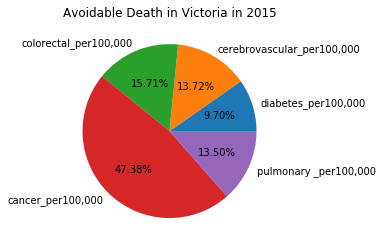

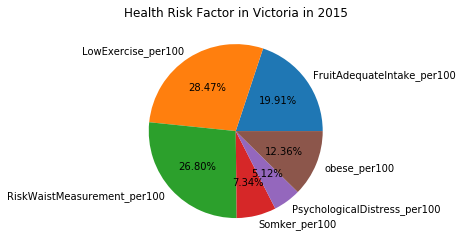

In [24]:
df1 = df_new_Avoidable_Death.sort_values(by = "Avoidable_Death_Total", ascending = False)
df2 = df_new_Health_Risk_Factor.sort_values(by = "Health_Risk_Factor_Total", ascending = False)
Key_df1 = df1.keys()
Key_df2 = df2.keys()


ax = plt.pie(df1.sum().iloc[:5], labels = Key_df1[:5], autopct = '%1.2f%%')
plt.title("Avoidable Death in Victoria in 2015")
plt.show(ax)


ax2 =plt.pie(df2.sum().iloc[:6], labels = Key_df2[:6], autopct = '%1.2f%%')
plt.title("Health Risk Factor in Victoria in 2015")
plt.show(ax2)

### Analysis 

- Around 47.38% avoidable death caused by cancer. People should go to hospital for diagnosing cancer desease regularly. 
- Almost 68% people with risk waist mearsurement, low exercise as well as obese, I suggest we should encourage people to do more exercise and build more public exercising places such as green park and public sports equipment.

## VAT for number of clusters

### VAT Function from week6 WS

In [25]:
import numpy as np
import math,random
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline



def VAT(R):
    """

    VAT algorithm adapted from matlab version:
    http://www.ece.mtu.edu/~thavens/code/VAT.m

    Args:
        R (n*n double): Dissimilarity data input
        R (n*D double): vector input (R is converted to sq. Euclidean distance)
    Returns:
        RV (n*n double): VAT-reordered dissimilarity data
        C (n int): Connection indexes of MST in [0,n)
        I (n int): Reordered indexes of R, the input data in [0,n)
    """
        
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
        
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)


    I = i[j]
    del J[I]

    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    
    C = [1,1]
    for r in range(2, N-1):   
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)        
        y = np.min(y)      
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])
    
    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)
    
    I.extend(J)
    C.extend(i)
    
    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    
    return RV.tolist(), C, I




### VAT 

In [26]:
df3 = pd.DataFrame({'Avoidabel_Death_Total': BigDF['Avoidable_Death_Total']})

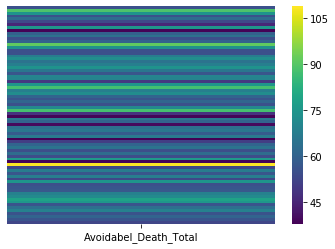

In [27]:
sns.heatmap(df3,cmap='viridis',xticklabels=True,yticklabels=False)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


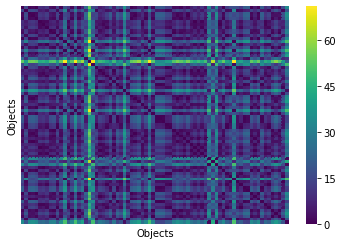

In [28]:
####Visualise the dissimilarity matrix for Iris using a heatmap (without applying VAT)####
df4=df3.copy().as_matrix()
np.random.shuffle(df4)   ####randomise the order of rows (objects)
sq = squareform(pdist(df4))   ###commpute the dissimilarity matrix
ax=sns.heatmap(sq,cmap='viridis',xticklabels=False,yticklabels=False)
ax.set(xlabel='Objects', ylabel='Objects')
plt.show()

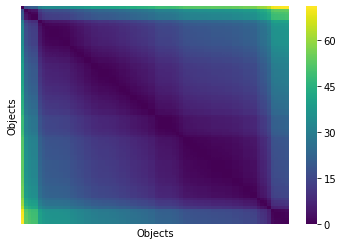

In [29]:
#####Apply VAT Algorithm to Iris dataset and visualise using heatmap########
RV, C, I = VAT(df3)
x=sns.heatmap(RV,cmap='viridis',xticklabels=False,yticklabels=False)
x.set(xlabel='Objects', ylabel='Objects')
plt.show()

### VAT Analysis 

- From VAT graph above, we can see there are about 3 clusters in Avoidable_Death_Total

### Plot Clustering on Map of Victorial ON AURIN 

Export the avoidable death file, for later clustering on AURIN.
The cluster number will be 3

In [30]:
df_new_Avoidable_Death['Avoidable_Death_Total'] = BigDF['Avoidable_Death_Total']
df_new_Avoidable_Death['lga_code'] = BigDF['lga_code']
df_new_Avoidable_Death['lga_name'] = BigDF['lga_name']

In [31]:
df_new_Avoidable_Death.to_csv('new_avoidable.csv', sep = ',')

## More Scatter Plot 

In [32]:
Avoidable_Death_Total = BigDF["Avoidable_Death_Total"]

In [33]:
# Function for scatter ploting and compute pearson correlation as well as linear regression
# @Argument: s1(Series) s2(Series) health_risk_factor_name(string)
# Return: None
def Scatter_and_Pearson_Corr(s2, s1, health_risk_factor_name):
    # Scatter plot
    plt.scatter(s1, s2, color='red')
    plt.title("Total Avoidable Death per 100,000\n VS. "+ health_risk_factor_name)
    plt.ylabel("Population  "+ health_risk_factor_name)
    plt.xlabel("Total Avoidable Death per 100,000")

    # plot the linear regression line
    Info = linregress(s1, s2)
    LinearRegressionLinePlot(Info[0], Info[1])
    plt.show()

    print("Slope:%.2f," % (Info[0]), "Intercept:%.2f." % (Info[1]))
    print("Pearson r is %.2f" % (s1.corr(s2)))

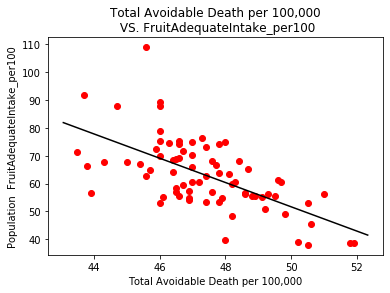

Slope:-4.36, Intercept:269.59.
Pearson r is -0.63


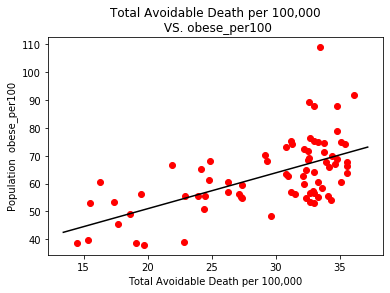

Slope:1.29, Intercept:25.26.
Pearson r is 0.60


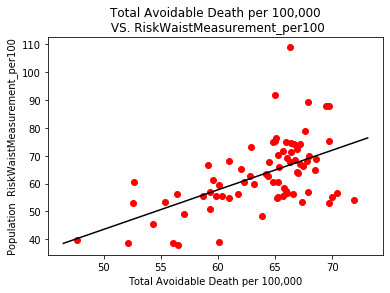

Slope:1.42, Intercept:-27.47.
Pearson r is 0.55


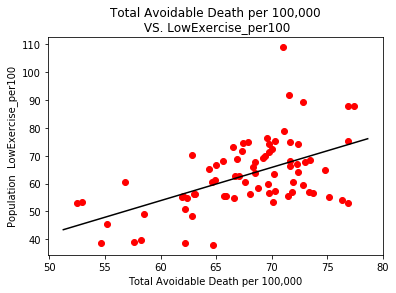

Slope:1.19, Intercept:-17.57.
Pearson r is 0.54


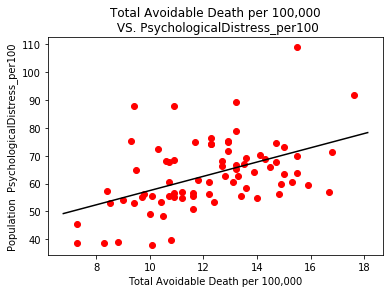

Slope:2.56, Intercept:31.89.
Pearson r is 0.47


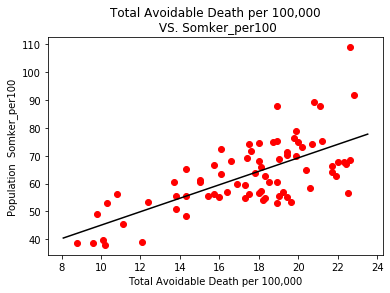

Slope:2.42, Intercept:20.90.
Pearson r is 0.68


In [34]:
Scatter_and_Pearson_Corr(Avoidable_Death_Total, BigDF['FruitAdequateIntake_per100'],\
                         "FruitAdequateIntake_per100")
Scatter_and_Pearson_Corr(Avoidable_Death_Total, BigDF['obese_per100'],\
                         "obese_per100")
Scatter_and_Pearson_Corr(Avoidable_Death_Total, BigDF['RiskWaistMeasurement_per100'],\
                         "RiskWaistMeasurement_per100")
Scatter_and_Pearson_Corr(Avoidable_Death_Total, BigDF['LowExercise_per100'],\
                         "LowExercise_per100")
Scatter_and_Pearson_Corr(Avoidable_Death_Total, BigDF['PsychologicalDistress_per100'],\
                         "PsychologicalDistress_per100")
Scatter_and_Pearson_Corr(Avoidable_Death_Total, BigDF['Somker_per100'],\
                         "Somker_per100")

### Analysis 

From the scatter plot and pearson relation above, I would suggest peolpe take enough fruit and pay attention to reduce low exercise, obese, risk waist measurement, psychological distress as well as somking in order to prevent avoidable death.